## Cogs 182 Project 1: Blackjack
### Justin Yang, A15522072

This notebook was designed to run in order from top to bottom. The entire script takes ~15 minutes to run on my laptop. tqdm is used to track progress in for loops.

In [1]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

F:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Implementation

In [2]:
def draw():
    '''
    Draw a card from the deck: a numpy array containing number and color
    
    Index 1: uniformly sampled from 1 to 10 representing the card number
    Index 2: -1 indicates red, 1 indicates black
    
    '''
    return np.array([np.random.randint(1, 11), np.random.choice([-1,1], p = [1/3, 2/3])])

def step(state, action):    
    '''
    Take on step in the game's environment
    
    An action of 0 corresponds to a "hit", in which the agent draws a new card
    An action of 1 corresponds to a "stick", in which the agent ends the card drawing and the dealer plays
    
    If, at any time, the player's state is >21 or <0, the players busts 
    If the dealer busts, the player's wins
    Otherwise, the player with the largest sum wins (draw = 0 reward)
    
    '''
    
    if action == 0: # 0 corresponds to hit
        new_state = (state[0], state[1] + np.prod(draw()))
        if (new_state[1] > 21) or (new_state[1] < 0):
            reward = -1
            new_state = (0,0)
        else:
            reward = 0
    else: 
        dealer_score = dealer(state[0])
        reward = check_outcome(state[1], dealer_score)
        new_state = (0,0)
        
    return new_state, reward 

def dealer(shown_card):
    '''
    The dealer's playbook: draw until getting a score of 17 or greater and then flip the face down card
    
    '''
    
    score = shown_card
    
    while score < 17:
        score += np.prod(draw()) 
        if (score > 21) or (score < 0):
            return -1
        
    return score

def check_outcome(player, dealer):
    
    if (player > dealer) or (dealer > 21):
        return 1
    elif player == dealer:
        return 0
    else: 
        return -1

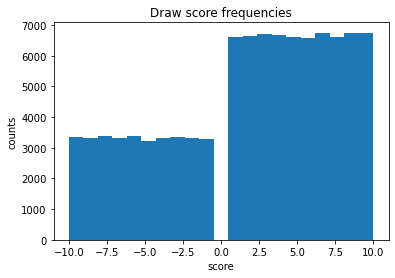

In [3]:
plt.hist([np.prod(draw()) for i in range(100000)], bins = 21)
plt.title('Draw score frequencies')
plt.xlabel('score')
plt.ylabel('counts');

#### Run implementation checks

In [4]:
# checkDraw output file
draws = np.array([draw() for i in range(1000)])
uniques, freq = np.unique(draws, axis=0, return_counts=True)
frequencies = np.hstack((uniques, freq.reshape(-1,1)/sum(freq)))
np.savetxt('checkDraw.txt', frequencies, fmt='%1.3f')

# checkStep#Dealer#Player#Action output files
for run in [[1,1,0],[2,10,0],[1,18,1],[10,15,1]]:
    draws = []
    for i in range(1000):
        tmp = step([run[0],run[1]],run[2])
        tmpa = list(tmp[0])
        tmpa.append(tmp[1])
        draws.append(tmpa)
    uniques, freq = np.unique(draws, axis=0, return_counts=True)
    frequencies = np.hstack((uniques, freq.reshape(-1,1)/sum(freq)))
    np.savetxt(f'checkStepDealer{run[0]}Player{run[1]}Action{run[2]}.txt', frequencies, fmt='%1.3f')

### Monte-Carlo Control

A state $S$ is defined on the space $\{1, 2, ..., 10\} \times \{1,2,...,21\}$ (excluding terminal state), corresponding to the number the dealer's first card and the player's sum.  <br>
An action $A$ is defined to be either $0$ or $1$, corresponding to a 'hit' or a 'stick', respectively.

In [5]:
def epsilon(state, ret_counts):
    return 10/ (10 + np.min(ret_counts[state[0], state[1]]))

def episode(state, action, ret_counts, qvalue):
    episodes = np.zeros((60,3)).tolist()
    episodes[0] = [state, action, 0]
    
    for ind, ep in enumerate(episodes):
        if ep[0] == (0,0):
            episodes = episodes[:ind + 1]
            break
        
        # get state given previous state-action pair
        state, reward = step(ep[0], ep[1])
        if np.random.random() < epsilon(state, ret_counts): 
            action = np.random.choice([0,1])
        else:
            action = np.argmax(qvalue[state[0], state[1]]) #, action

        episodes[ind + 1] = [state, action, reward]
    
    return list(reversed(episodes))

In [6]:
# initialize variables 
Q = np.zeros((11,22,2))
returns_counts = np.zeros((11,22,2))

# run Monte Carlo for 1 million episodes
for i in tqdm(range(1000000)):
    S_0 = np.random.choice(range(1,11)), np.random.choice(range(1,11)) # note: does not start on terminal state
    A_0 = np.random.choice([0,1])
    episodes = episode(S_0, A_0, returns_counts, Q)
    G = 0
    for ind, ep in enumerate(episodes[1:]): 
        G += episodes[ind][-1] 
        if [ep[0], ep[1]] not in [row[0:2] for row in episodes[ind+2:]]: 
            index = ep[0][0], ep[0][1], ep[1]
            returns_counts[index] += 1
            Q[index] += (G - Q[index]) / returns_counts[index] if returns_counts[index] != 0 else 10

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [07:34<00:00, 2201.25it/s]


In [7]:
V_star = np.max(Q, axis = 2)
Q_star = Q # for Sarsa(0) MSE calculation

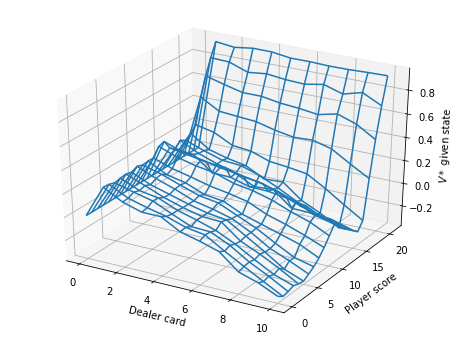

In [8]:
hf = plt.figure(figsize=(8,6))
ha = hf.add_subplot(111, projection='3d')

x = range(V_star.shape[0])
y = range(V_star.shape[1])
X, Y = np.meshgrid(x, y)
ha.plot_wireframe(X, Y, V_star.T)
ha.set_xlabel('Dealer card')
ha.set_ylabel('Player score')
ha.set_zlabel('$V*$ given state');

#### Run implementation checks

In [15]:
x = []
for i in range(11):
    for j in range(22):
        for k in range(2):
            x.append((i,j,k))
x = pd.DataFrame(x)
x[3] = pd.DataFrame(Q_star.flatten())
x = x.drop(np.arange(2,44))
np.savetxt('checkQ.txt', x.values, fmt='%1.3f')


#### extra plotting for fun

In [10]:
# %matplotlib notebook
# hf = plt.figure()
# ha = hf.add_subplot(111, projection='3d')

# x = range(V_star.shape[0])
# y = range(V_star.shape[1])
# X, Y = np.meshgrid(x, y)
# ha.plot_wireframe(X, Y, V_star.T)

# # rotate the axes and update
# for angle in range(0, 360):
#     ha.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [11]:
# from mpl_toolkits.mplot3d import axes3d
# from IPython.display import HTML
# import matplotlib.animation as animation

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # plot a wireframe
# x = range(V_star.shape[0])
# y = range(V_star.shape[1])
# X, Y = np.meshgrid(x, y)
# ax.plot_wireframe(X, Y, V_star.T)
# #ax.grid(False)
# #ax.set_axis_off()

# def init():
#     ax.plot_wireframe(X, Y, V_star.T, rstride=5, cstride=5)
#     return fig,

# def animate(i):
#     ax.view_init(elev=30., azim=3.6*i/3)
#     return fig,
# ax.set_xlabel('Dealer card')
# ax.set_ylabel('Player score')
# ax.set_zlabel('Optimal value')

# # Animate
# ani = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=300, interval=10, blit=True)    
# writergif = animation.PillowWriter(fps=30) 
# ani.save('blackjack_MC_values_fast.gif', writer=writergif)

### TD Learning
Implementing Sarsa(0)

In [12]:
def epsilon_greedy(state, ret_counts, qvalue):
    if np.random.random() < epsilon(state, ret_counts): 
        return np.random.choice([0,1])
    else:
        return np.argmax(qvalue[state[0], state[1]])

In [13]:
Q = np.zeros((11,22,2))
returns_counts = np.zeros((11,22,2))
mse = []
for i in tqdm(range(1000001)):
    S = np.random.choice(range(1,11)), np.random.choice(range(1,11)) # note: does not start on terminal state
    A = epsilon_greedy(S, returns_counts, Q)
    while S != (0,0):
        index = S[0], S[1], A
        returns_counts[index] += 1
        S_p, R = step(S,A)
        A_p = epsilon_greedy(S_p, returns_counts, Q)
        Q[index] += (R + Q[S_p[0], S_p[1], A_p] - Q[index]) / returns_counts[index] if returns_counts[index] != 0 else 10
        S, A = S_p, A_p
    if i % 10000 == 0:
        mse.append(np.sum((Q_star - Q)**2) / Q.size)

100%|██████████████████████████████████████████████████████████████████████| 1000001/1000001 [07:01<00:00, 2371.61it/s]


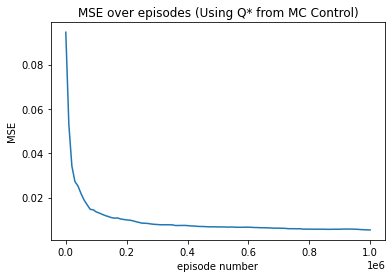

In [14]:
sns.lineplot(x = np.arange(len(mse)) * 10000, y = mse)
plt.xlabel('episode number')
plt.ylabel('MSE')
plt.title('MSE over episodes (Using Q* from MC Control)');